## Problema de Negócio

A Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes das lojas Rossmann são responsáveis por prever suas vendas diárias com até seis semanas de antecedência. As vendas das lojas são influenciadas por muitos fatores, incluindo promoções, competição, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes individuais prevendo as vendas com base em suas circunstâncias únicas, a precisão dos resultados pode ser bastante variada.

Para a construção de um plano estratégico para o alavancamento das vendas, os gerentes da Rossmann solicitou ao superientendente uma análise de quais fatores podem impactar positivamente ou negativamente as vendas. Com informações dessa natureza, os gerentes da Rossmann conseguem ajustar os planos com o objetivo de obterem o maior retorno possível.

Sendo assim, nosso objetivo é estruturar uma análise para responder a esses questionamentos para que o superintendente junto de seus gerentes criem planos de ações mais personalizados e estruturados.

## 0.0 Pacotes e Bibliotecas

In [ ]:
import pandas as pd
import numpy  as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing, linear_model, model_selection, metrics

from matplotlib import pyplot as plt
from datetime import datetime
from scipy.stats import pointbiserialr, shapiro

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1.0 Carregamento dos Dados

Para a nossa análise, vamos trabalhar com duas bases. A primeira base nos tras informações sobre as vendas das drogarias das redes Rossmann. Também temos a base que possui informações das características dessas lojas, isto é, uma tabela fato que carrega informações cadastrais.

In [2]:
# Carregamento dos Dados
df_vendas = pd.read_csv('../BaseDados/DadosTreino.csv', delimiter=',', low_memory=False)
dados_cadastrais_loja = pd.read_csv('../BaseDados/DadosLoja.csv', delimiter=',', low_memory=False)

In [3]:
# Amostra dos dados de vendas das lojas
print(f"Quantidade de Linhas: {df_vendas.shape[0]}; Quantidade de Colunas: {df_vendas.shape[1]}")
df_vendas.head()

Quantidade de Linhas: 1017209; Quantidade de Colunas: 9


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
# Amostra dos dados de cadastros da Loja
print(f"Quantidade de Linhas: {dados_cadastrais_loja.shape[0]}; Quantidade de Colunas: {dados_cadastrais_loja.shape[1]}")
dados_cadastrais_loja.head()

Quantidade de Linhas: 1115; Quantidade de Colunas: 10


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


**Construção da Base**

In [5]:
# Junção dos Dados cadastrais com os dados de venda
df1 = df_vendas.merge(dados_cadastrais_loja, how='left', on='Store')

# Analise de Volumetria
print(f"Quantidade de Linhas: {df1.shape[0]}; Quantidade de Colunas: {df1.shape[1]}.")

# Amostra dos Dados
df1.sample(10)

Quantidade de Linhas: 1017209; Quantidade de Colunas: 18.


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
30960,856,6,2015-07-04,5741,743,1,0,0,0,a,a,3020.00,2.00,2010.00,0,NaN,NaN,NaN
590558,394,6,2014-01-18,8039,676,1,0,0,0,d,a,10850.00,NaN,NaN,0,NaN,NaN,NaN
45970,256,6,2015-06-20,7600,1004,1,0,0,0,a,c,80.00,9.00,2005.00,1,10.00,2014.00,"Mar,Jun,Sept,Dec"
659318,24,7,2013-11-17,0,0,0,0,0,0,a,c,4590.00,3.00,2000.00,1,40.00,2011.00,"Jan,Apr,Jul,Oct"
120637,218,2,2015-04-14,5997,796,1,1,0,0,a,c,640.00,NaN,NaN,1,9.00,2011.00,"Mar,Jun,Sept,Dec"
536233,704,6,2014-03-08,6667,696,1,0,0,0,d,c,1910.00,4.00,2009.00,0,NaN,NaN,NaN
448990,431,7,2014-05-25,0,0,0,0,0,0,d,c,4520.00,NaN,NaN,0,NaN,NaN,NaN
270034,1110,3,2014-11-26,5472,562,1,1,0,0,c,c,900.00,9.00,2010.00,0,NaN,NaN,NaN
643155,586,1,2013-12-02,25859,3522,1,1,0,0,a,c,250.00,10.00,2008.00,0,NaN,NaN,NaN
223939,940,1,2015-01-12,7332,780,1,1,0,0,d,c,6470.00,9.00,2012.00,0,NaN,NaN,NaN


Com a nossa base construída e com os dados prontos, vamos construir o nosso dicionário de dados para entender melhor as nuances do negócio e seus detalhes.

### 1.1 Visão Geral dos Dados

Nessa etapa queremos, apenas, de forma geral ver como estão as estruturas de tipos de dados e os nomes das colunas.

In [6]:
df1.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

Na visão geral, não temos problemas com os nomes das colunas e, os tipos dos dados, estão dentro do esperado.

Em seguida, para que possamos dar continuidade ao nosso projeto, precisamos construir nosso dicionário de dados para entender as regras, os detalhes e a história que o dado conta.

### 1.2 Dicionário de Dados

Logo abaixo, temos o dicionário dados para entender o que nos diz os dados e, além disso, construímos um dataframe com o objetivo de acessar esse dicionario de forma mais rápida.

**Store**: Um identificador único para cada loja.

**Sales**: O faturamento de qualquer dia específico (isso é o que você está prevendo).

**Customers**: O número de clientes em um dado dia.

**Open**: Um indicador se a loja estava aberta: 0 = fechada, 1 = aberta.

**StateHoliday**: Indica um feriado estadual. Normalmente, todas as lojas, com poucas exceções, estão fechadas em feriados estaduais. Note que todas as escolas estão fechadas em feriados públicos e fins de semana. a = feriado público, b = feriado de Páscoa, c = Natal, 0 = Nenhum.

**SchoolHoliday**: Indica se a (Loja, Data) foi afetada pelo fechamento das escolas públicas.

**StoreType**: Diferencia entre 4 modelos de lojas diferentes: a, b, c, d.

**Assortment**: Descreve um nível de sortimento: a = básico, b = extra, c = estendido.

**CompetitionDistance**: Distância em metros até a loja concorrente mais próxima.

**CompetitionOpenSinceMonth/Year**: Dá o ano aproximado e o mês em que a loja concorrente mais próxima foi aberta.

**Promo**: Indica se uma loja está realizando uma promoção nesse dia.

**Promo2**: Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando.

**Promo2SinceYear/Month:** Descreve o ano e a semana do calendário em que a loja começou a participar da Promo2.

**PromoInterval**: Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é reiniciada. Por exemplo, "Fev, Mai, Ago, Nov" significa que cada rodada começa em fevereiro, maio, agosto e novembro de qualquer ano para aquela loja.

In [7]:
# Colunas
campos = ['Store', 
          'Sales', 
          'Customers', 
          'Open', 
          'StateHoliday', 
          'SchoolHoliday', 
          'StoreType', 
          'Assortment', 
          'CompetitionDistance', 
          'CompetitionOpenSinceMonth', 
          'CompetitionOpenSinceYear', 
          'Promo', 
          'Promo2', 
          'Promo2SinceMonth', 
          'Promo2SinceYear', 
          'PromoInterval',
          'CompetitionOpenSinceMonth',
          'CompetitionOpenSinceYear']

# Informações dos Campos
info = ['Id único de identificação da loja', 
        'Faturamento do dado dia', 
        'Número de clientes do dados dia', 
        'Indicador que diz se a loja estava aberta ou fechada. 0 = Fechada e 1 = Aberta', 
        'Indica um feriado estadual. Normalmente, todas as lojas, com poucas exceções, estão fechadas em feriados estaduais. Note que todas as escolas estão fechadas em feriados públicos e fins de semana. a = feriado público, b = feriado de Páscoa, c = Natal, 0 = Nenhum.',
        'Indica se a loja foi afeta pelo fechamento das escolas públicas nos feriados escolares', 
        'Diferencia entre 4 modelos de lojas diferentes: a, b, c, d.', 
        'Descreve a variedade de produtos que a drogaria trabalha: a = básico, b = extra, c = estendido.',
        'Distância em metros até a loja concorrente mais próxima', 
        'Dá o mês em que a loja concorrente mais próxima foi aberta.', 
        'Dá o ano em que a loja concorrente mais próxima foi aberta',
        'Indica se uma loja está realizando uma promoção nesse dia.', 
        'É uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando.', 
        'Descreve o mes e a semana do calendário em que a loja começou a participar da Promo2.',
        'Descreve o ano e a semana do calendário em que a loja começou a participar da Promo2.', 
        'Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é reiniciada. Por exemplo, "Fev, Mai, Ago, Nov" significa que cada rodada começa em fevereiro, maio, agosto e novembro de qualquer ano para aquela loja.',
        'Dá o mês aproximado em que a loja concorrente mais próxima foi aberta',
        'Dá o ano aproximado em que a loja concorrente mais próxima foi aberta']
dicionario_dados = pd.DataFrame({'Informação': info}, index=campos)

In [8]:
# Testando o dicionário de Dados
dicionario_dados['Informação']['StateHoliday']

'Indica um feriado estadual. Normalmente, todas as lojas, com poucas exceções, estão fechadas em feriados estaduais. Note que todas as escolas estão fechadas em feriados públicos e fins de semana. a = feriado público, b = feriado de Páscoa, c = Natal, 0 = Nenhum.'

Ao compreender o que os dados nos dizem e, o nosso objetivo, que é entender quais fatores impactam no faturamento diário, vamos eliminar algumas variáveis que não fazem sentido nenhum, no caso, são as variáveis:

* Promo2SinceYear
* Promo2SinceMonth

In [9]:
# Eliminando as variáveis desnecessárias
df1 = df1.drop(['Promo2SinceWeek', 'Promo2SinceYear'], axis=1).copy()

# Analise de Volumetria
print(f"Quantidade de Linhas: {df1.shape[0]}; Quantidade de Colunas: {df1.shape[1]}.")

Quantidade de Linhas: 1017209; Quantidade de Colunas: 16.


Visto que os dados, de forma geral, está com uma estrutura inicialmente aceitável e, com um dicionário de dados bem estruturado, podemos iniciar nosso projeto de fato.

## 2.0 Análise Exploratória dos Dados

In [10]:
# Cópia dos Dados
df2 = df1.copy()

Lembremos que, o nosso objetivo, é entender quais fatores impactam nas vendas das lojas. Para isso, temos que ter um mente uma variável alvo que, nesse caso, será a Sales. Sendo assim, vamos primeiramente, verificar a distribuição da variável alvo.

### 2.1 Variável Alvo

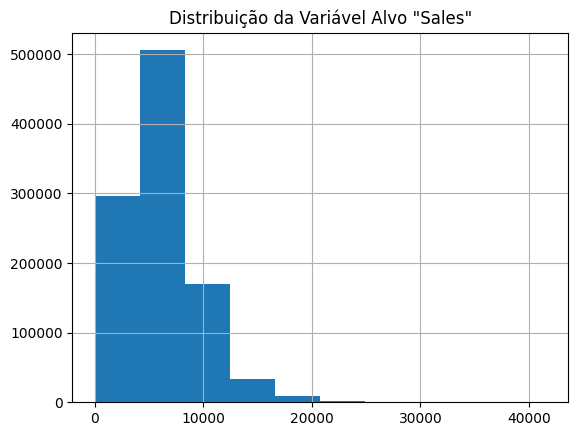

In [11]:
# Distribuição da nossa variável alvo.
df2['Sales'].hist();
plt.title('Distribuição da Variável Alvo "Sales"')
plt.show()

Podemos ver que temos uma variável com uma distribuição concentrada mais a esquerda, isto é, as lojas da rede Rossmann possuem vendas diárias que estão concentradas principalmente no intervalo de US$ 0,00 a US$ 10.000,00.

### 2.2 Resumo Estatístico dos Dados

**Variáveis Numéricas**

In [12]:
# Resumo Estatístico dos dados numéricos
df2_numerico = df2.select_dtypes(exclude=['object'])

# Amostra dos Dados
df2_numerico.sample(5)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
841457,418,5,6107,670,1,1,0,1060.00,5.00,2009.00,1
556645,1046,2,10304,716,1,1,0,29070.00,4.00,2005.00,0
248882,414,4,8831,609,1,1,0,6210.00,NaN,NaN,1
128561,337,2,4416,373,1,0,1,10600.00,7.00,2005.00,1
866460,891,4,6728,973,1,1,0,350.00,NaN,NaN,1


In [13]:
# Obtendo o resumo estatístico
df2_numerico.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1014567.00,693861.00,693861.00,1017209.00
mean,558.43,4.00,5773.82,633.15,0.83,0.38,0.18,5430.09,7.22,2008.69,0.50
std,321.91,2.00,3849.93,464.41,0.38,0.49,0.38,7715.32,3.21,5.99,0.50
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,20.00,1.00,1900.00,0.00
25%,280.00,2.00,3727.00,405.00,1.00,0.00,0.00,710.00,4.00,2006.00,0.00
50%,558.00,4.00,5744.00,609.00,1.00,0.00,0.00,2330.00,8.00,2010.00,1.00
75%,838.00,6.00,7856.00,837.00,1.00,1.00,0.00,6890.00,10.00,2013.00,1.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00,75860.00,12.00,2015.00,1.00


Quando analisamos o resumo estatístico, podemos ver a presença de dados nulos na variável CompetitionDistance. Além disso, podemos observar traços de outilers, como por exemplo, na nossa variável alvo 'Sales'. Uma outra variável que apresenta possuir problemas é a variável CompetitionOpenSincYear. A menor data que nós temos é 1900, entretanto, com uma breve pesquisa das redes Rossman, temos que a primeira loja dela foi inaugurada em 1972. Logo, existe alguns problemas nessa variável que terem que ser melhores entendidas e tratadas.

**Variáveis Categóricas**

In [14]:
# Extraindo as variáveis categóricas
df2_categorica = df2.select_dtypes(include=['object'])

# Amostra dos dados
df2_categorica.sample(5)

,Date,StateHoliday,StoreType,Assortment,PromoInterval
224247,2015-01-11,0,a,a,"Mar,Jun,Sept,Dec"
111725,2015-04-22,0,a,a,NaN
909898,2013-04-07,0,a,a,"Feb,May,Aug,Nov"
297216,2014-10-27,0,a,c,NaN
155543,2015-03-14,0,d,a,"Feb,May,Aug,Nov"


In [15]:
# Resumo Estatístico
df2_categorica.describe()

,Date,StateHoliday,StoreType,Assortment,PromoInterval
count,1017209,1017209,1017209,1017209,509178
unique,942,4,4,3,3
top,2013-01-02,0,a,a,"Jan,Apr,Jul,Oct"
freq,1115,986159,551627,537445,293122


Nesse resumo estatístico, podemos ver que a nossa variável de data está como objeto, sendo assim, conseguimos identificar um tratamento a ser realizado. Além disso, o resumo estatístico nos diz que a maioria dos dias de vendas são dias que não são feriados e, além disso, a maioria das lojas são do tipo a em que, no geral, vendem só o básico. Além disso, o PromoInterval possui presença de dados nulos.

### 2.3 Análise Geral do Dataset

Ao analisar o resumo estatístico, identificamos alguns possíveis tratamentos que o nosso dataset precise, no caso, tratamento de dados nulos e outliers, além de tratamento de data. Para que todo o nosso trabalho seja feito de forma efetiva e, tudo que seja, não seja em vão, vamos analisar o nosso dataset de forma geral, isto é, vamos observar se, as informações que ele trás faz sentido ou não.

In [16]:
# Definindo função para estudo de relaçaõ
def analise_pares(dados, variavel_dependente, variaveis_independentes, n):

    # Grupo de linhas com n gráficos por linha
    grupo_variaveis_independendentes = [variaveis_independentes[i:i+n] for i in range(0, len(variaveis_independentes), n)]

    # Loop pelos grupos de linhas para criar cada pair plot
    for grupo_variaveis in grupo_variaveis_independendentes:
        plot = sns.pairplot(x_vars=grupo_variaveis, 
                            y_vars=variavel_dependente, 
                            data=dados, 
                            kind = "reg", 
                            height=3)

**Variáveis Numéricas**

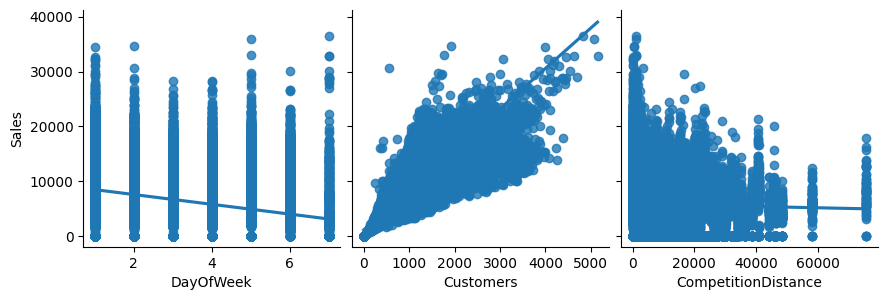

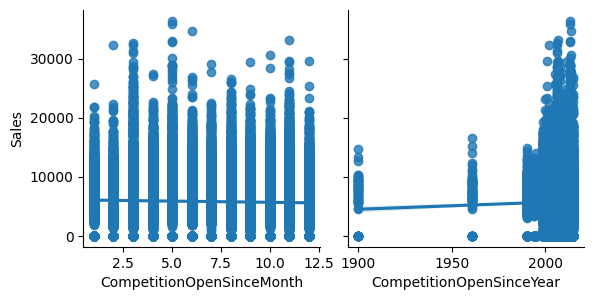

In [17]:
# Selecionando as variáveis numéricas
variaveis_independentes = ['DayOfWeek', 'Customers', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']
variavel_dependente = 'Sales'

# Realizando a Análise de pares
analise_pares(df2.sample(n=100000), variavel_dependente, variaveis_independentes, 3)

**Variáveis Binárias**

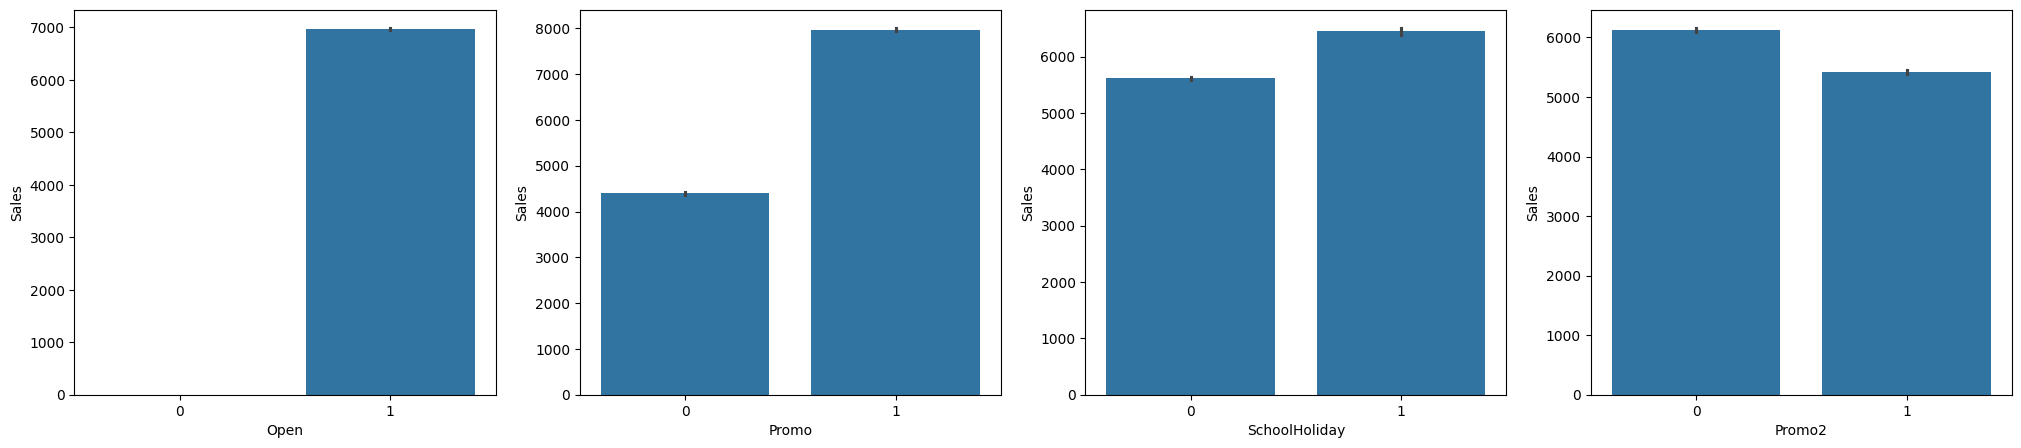

In [18]:
# Criando o grid de plotagem
fig, ax = plt.subplots(1, 4, figsize=(25,5));

# Plotando os Gráficos
sns.barplot(x='Open', y='Sales', data=df2.sample(n=100000), ax=ax[0]);
sns.barplot(x='Promo', y='Sales', data=df2.sample(n=100000), ax=ax[1]);
sns.barplot(x='SchoolHoliday', y='Sales', data=df2.sample(n=100000), ax=ax[2]);
sns.barplot(x='Promo2', y='Sales', data=df2.sample(n=100000), ax=ax[3]);

**Variáveis Categóricas**

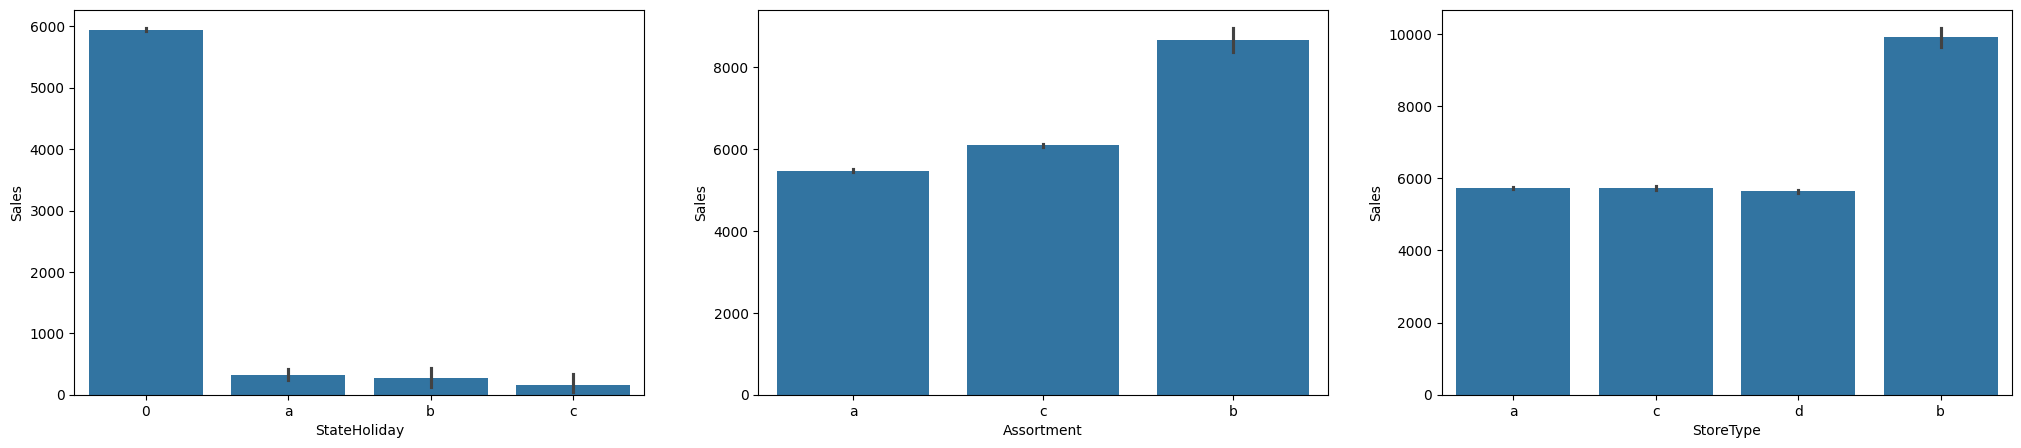

In [19]:
# Criando o grid de plotagem
fig, ax = plt.subplots(1, 3, figsize=(25,5));

# Plotando os Gráficos
sns.barplot(x='StateHoliday', y='Sales', data=df2.sample(n=100000), ax=ax[0]);
sns.barplot(x='Assortment', y='Sales', data=df2.sample(n=100000), ax=ax[1]);
sns.barplot(x='StoreType', y='Sales', data=df2.sample(n=100000), ax=ax[2]);

**Relatório**

*Day of Week*: Durante os primeiros dias da semana ocorre um maior volume no faturamento e, com a chegada do final de semana, o volume diminui, pois ocorre uma menor movimentação de pessoa durante as sextas, sábados e domingos em drogarias.

*Customers:* Com o aumento de clientes nas drogarias, ocorre o aumento de faturamento, pois são mais pessoas realizando compras.

*CompetitionDistance:* Ao analisar nosso gráfico, podemos ver uma leve tendência de queda na nossa regressão. Quando olhamos nosso scatterplot, percebemos um menor volume com o aumento da distância de um concorrente. Claramente, uma drogaria que possui um concorrente mais próximo realizará mais ações de promoções para que seja mais competitiva, logo isso acarreta em um aumento de volume de vendas, em contrapartida, com um concorrente mais distante, não é tão válido fazer promoções o que pode não impactar em tanto volume de vendas. 

*Open:* Claramente, lojas que estão abertas possuem maior volume de vendas.

*Promo:* Lojas que estão em promoção tendem a ter um maior volume de vendas já que esse é o objetivo de uma promoção.

*SchoolHoliday*: Aqui nós temos um comportamento interessante. As escolas que são afetadas pelo feriado escolar possuem um valor de faturamento maior que lojas que não são afetadas por feriados escolares. Se um drogaria é afetada por esse tipo de feriado, logo, ela está localizada perto de uma escola e, sendo assim, existe uma movimentação grande de segunda a sábado nesse local, logo, mesmo que o feriado afete o faturamento, nos outros dias, o valor é compensado por essa movimentação. Sendo assim, o faturamento de drogarias que são afetadas por escolas é maior.

*Promo2:* Uma promoção ela possui força apenas por um tempo, no caso, no seu início. Após os clientes já terem adquiridos os seus produtos eles não vão comprar outros tão rapidamente. Sendo assim, se uma promoção dura por muito tempo, ela deixa de gerar um faturamento esperado.

*StateHoliday:* Claramente, o faturamento é maior em datas que não são feriados.

*Assortment:* Uma observação interessante aqui é que, drogarias com uma variedade básica ou estendida faturam menos que uma drogaria que possui um variedade um pouco maior que o básico e menor do que a estendida. O básico deixa de atender muitas situações específicas o que acarreta em perca de faturamente. Por outro lado, uma drogaria com uma variedade muito garnde possui produtos desnecessário, o qual, possuem baixa rotatividade impactando no volume de vendas.

*StoreType:* Não temos detalhes sobre o tipo da loja, mas, vemos que todas faturam e, especificamente, a loja tipo b possui maior faturamento.

*CompetitionOpenSinceYearMonth*: Ao Analisar, não vemos uma diferença tão interessante em relação ao tempo de abertura de um competidor e as vendas. Logo, isso mostra que as lojas são constantes em suas vendas e consegue mantê-las bem.

Ao realizar essa análise, podemos dar continuidade ao nosso projeto, pois os dados fazem sentido. Sendo assim, podemos iniciar a fase de tratamento e limpeza.

### 2.4 Tratamento de Data

In [20]:
# Tratamento da Colunas de Data
df2['Date'] = pd.to_datetime(df2['Date'], format='%Y-%m-%d')

# Verificando a tipagem do dado
df2.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
PromoInterval                        object
dtype: object

### 2.5 Tratamento de Dados Nulos

In [21]:
# Identificando as variáveis com dados nulos
df2.isna().sum()[df2.isna().sum() > 0]

CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
PromoInterval                508031
dtype: int64

As variáveis que possuem dados nulos são CompetitionDistance, PromoInterval, CompetitionOpenSinceMonth, CompetitionOpenSinceYear. Vamos analisar a natureza desses dados e o percentual representativos em relação ao todo

In [22]:
# Identificando as variáveis com dados nulos
df2.isna().sum()[df2.isna().sum() > 0]/df2.shape[0]

CompetitionDistance         0.00
CompetitionOpenSinceMonth   0.32
CompetitionOpenSinceYear    0.32
PromoInterval               0.50
dtype: float64

Podemos ver que a quantidade de dados nulos da variável CompetitionDistance é irrisório. Logo, vamos eliminar os dados nulos da CompetitionDistance. Em contrapartida, não podemos aplicar a mesma técnica para quando analisamos a varriável PromoInterval. Nesse caso a variável nula representa uma loja qe não estava em promo2. Logo, podemos preencher os dados nulos desse atributo com essa informação, no caso, withoutpromo2. 

Para as variáveis CompetitionOpenSinceMonth e CompetitionopenSinceYear não podemos apenas eliminá-las, pois elas representam 32% do nosso dataset. Analisando esssas variáveis, no caso, CompetitionOpenSinceMonth e CompetitionOpenSinceYear, temos algumas considerações a se fazer. Quando observamos as informações que estão inseridas como 1900 e 1950, provavelmente ocorreu algum erro de digitação, uma vez que a primeira loja da rede rossmann foi fundada em 1972. Sendo assim, vamos precisar tomar algumas decisões sobre o tratamento dos dados nulos que nós temos.

Vamos iniciar o tratamento da variável PromoInterval

In [23]:
# Tratando os dados nulos
df2['PromoInterval'] = np.where(pd.isna(df2['PromoInterval']), 'WithoutPromo2', df2['PromoInterval'])

# Validando a quantidade de dados nulos
print(f'Quantidade de Dados Nulos')
print(df2.isna().sum()[df2.isna().sum() > 0])

Quantidade de Dados Nulos
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
dtype: int64


Vamos analisar os dados em que a variável CompetitionSinceYear e CompetitionSinceMonth.

Com uma minuciosa observação dos dados nulos de CompetitionOpenSinceYear e CompetitionOpenSinceMonth adicionado com a análised da variável CompetitionDistance, concluímos que ocorreu uma possível falha na inserção dos dados nessas variáveis que trataremos. Dizemos isso, pois tem casos no nosso dataset em que as variáveis CompetitionOpenSinceYear/Month são nulas e a variável CompetitionDistance não é nula. A toma de decisão que vamos ter aqui para tratar os dados nulos será considerar a data mais antiga de faturamento da loja e, com essa informação, preenchermos com o ano e o mês as variáveis CompentitionOpenSinceYear e CompentitionOpenSinceMonth, respectivamente. 

In [24]:
# Obtendo a lista de lojas
lista_lojas = df2['Store'].unique().tolist()

# Inicio do Loop
for loja in lista_lojas:

    # Critério para saber se a loja possui dados nulos
    if (np.sum(df2[df2['Store'] == loja]['CompetitionOpenSinceYear'].isna()) >= 1):
        
        # Obtendo o ano mais recente
        min_date_year = np.min(df2[df2['Store'] == loja]['Date']).year

        # Obtendo o mês mais recente
        min_date_month = np.min(df2[df2['Store'] == loja]['Date']).month

        # Tratando os dados nulos de ano
        df2.loc[df2['Store'] == loja, 'CompetitionOpenSinceYear'] = np.where(df2.loc[df2['Store'] == loja, 'CompetitionOpenSinceYear'].isna(), min_date_year, df2.loc[df2['Store'] == loja, 'CompetitionOpenSinceYear'])
        
        # Tratando os dados nulos de mês
        df2.loc[df2['Store'] == loja, 'CompetitionOpenSinceMonth'] = np.where(df2.loc[df2['Store'] == loja, 'CompetitionOpenSinceMonth'].isna(), min_date_month, df2.loc[df2['Store'] == loja, 'CompetitionOpenSinceMonth'])

In [25]:
# Validação dos Dados NUlos
df2.isna().sum()[df2.isna().sum() > 0]

CompetitionDistance    2642
dtype: int64

Por fim, sobrou apenas os dados nulos da variável competitionDistance que são muito poucos. Nessa situação, optamos por eliminá-los.

In [26]:
# Dropando os restantes de dados nulos
df2 = df2.dropna()

# Validando os dados nulos
df2.isna().sum()[df2.isna().sum() > 0]

Series([], dtype: int64)

In [27]:
# Analise de Volumetria
print(f'Quantidade de Linhas: {df2.shape[0]}; Quantidade de Colunas: {df2.shape[1]}.')

Quantidade de Linhas: 1014567; Quantidade de Colunas: 16.


Com os dados nulos tratados, a nossa próxima etapa é a verificação de outliers no nosso conjunto de dados.

### 2.5 Tratamento de Outliers

Nessa etapa, queremos identicar outliers em nosso conjunto de dados. Nesse caso, faz sentido identificá-los apenas algumas variáveis que, no caso, são: Sales, Customer e CompetitioDistance.

In [28]:
# Selecionando as variáveis necessárias
df2_atributos_numericos = df2[['Customers', 'CompetitionDistance', 'Sales']].copy()

In [29]:
# Calculando os intervalos interquartis
q1 = df2_atributos_numericos.quantile(0.25)
q3 = df2_atributos_numericos.quantile(0.75)
intervalo_interquartil = q3 - q1

# Calculando os limites
limite_superior = q3 + 1.5*intervalo_interquartil
limite_inferior = q1 - 1.5*intervalo_interquartil

# Obtendo os outliers
outliers = ((df2_atributos_numericos > limite_superior) | (df2_atributos_numericos < limite_inferior)) 

# Verificando a quantidade de outliers
print(f'Quantidade de Outliers')
print(outliers.sum())
print(f'Percentual Representativo em %')
print(outliers.sum()/df2_atributos_numericos.shape[0]*100)

Quantidade de Outliers
Customers              38089
CompetitionDistance    99160
Sales                  26674
dtype: int64
Percentual Representativo em %
Customers             3.75
CompetitionDistance   9.77
Sales                 2.63
dtype: float64


Ao analisar o percentual representativo, temos algo em torno de 10% de outliers, no geral. Logo, vamos excluir esses outliers para uma primeira versão e avaliaremos nosso resultado mais a frente. Caso não dê certo, tomamos mais decisões. 

In [30]:
# Selecionando os dados que não são outliers
df2_sem_outliers = df2[~outliers.any(axis=1)].reset_index(drop=True)

# Validando a volumetria dos dados e a quantidade de dados nulos
# Analise de Volumetria
print(f"Quantidade de Linhas: {df2_sem_outliers.shape[0]}; Quantidade de Colunas: {df2_sem_outliers.shape[1]}.")
print(f"Quantidade de Dados Nulos: {df2_sem_outliers.isna().sum().sum()}.")

Quantidade de Linhas: 871882; Quantidade de Colunas: 16.
Quantidade de Dados Nulos: 0.


Com uma quantidade zero de dados nulos e com uma quantidade de dados bem representativa, podemos dar continuidade a modelagem dos nossos dados.

### 2.7 Validação Final dos Dados

Com os dados devidamente tratados e modelados, vamos para a nossa validação final para verificar como ficou a distribuição após a remoção de outliers e valores nulos.

In [31]:
df2_sem_outliers.select_dtypes(include=['float64', 'int64']).describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
count,871882.00,871882.00,871882.00,871882.00,871882.00,871882.00,871882.00,871882.00,871882.00,871882.00,871882.00
mean,557.57,4.04,5338.46,574.56,0.82,0.37,0.18,3506.78,5.30,2010.03,0.53
std,324.17,2.00,3278.88,354.05,0.38,0.48,0.38,3782.60,3.96,5.51,0.50
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,20.00,1.00,1900.00,0.00
25%,277.00,2.00,3599.00,393.00,1.00,0.00,0.00,640.00,1.00,2008.00,0.00
50%,555.00,4.00,5576.00,594.00,1.00,0.00,0.00,2100.00,4.00,2012.00,1.00
75%,843.00,6.00,7502.00,803.00,1.00,1.00,0.00,4970.00,9.00,2013.00,1.00
max,1115.00,7.00,14049.00,1485.00,1.00,1.00,1.00,15770.00,12.00,2015.00,1.00


In [32]:
# Analise Final
print(f"Quantidade de Dados Nulos: {df2_sem_outliers.isna().sum().sum()}")
print(f"Quantidade de Linhas: {df2_sem_outliers.shape[0]}; Quantidade de Colunas: {df2_sem_outliers.shape[1]}.")

Quantidade de Dados Nulos: 0
Quantidade de Linhas: 871882; Quantidade de Colunas: 16.


Podemos ver que nossos dados nulos já foram tratados, entretando, observe que temos anos de competição com valor de 1900. Feito nosso levantamento, temos um problema no nosso dataset. Vamos analisar esses dados.

### 2.8 Tratamento de Anomalias 

In [33]:
# Quantidade de Dados
print(f'Quantidade de Linhas:{df2_sem_outliers[df2_sem_outliers['CompetitionOpenSinceYear'] == 1900].shape}.')

Quantidade de Linhas:(751, 16).


Com uma quantidade muita pequena, não vale o esforço aplicado, inicialmente, para tratar esses dados. Vamos dropá-lo.

In [34]:
# Obtendo os dados necessários
df2_tratado = df2_sem_outliers[df2_sem_outliers['CompetitionOpenSinceYear']!=1900]

# Quantidade de Dados NUlos
print(f'Quantidade de Dados Nulos: {df2_tratado.isna().sum().sum()}.')

# Resumo Estatístico
df2_tratado.describe()

Quantidade de Dados Nulos: 0.


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
count,871131.00,871131.00,871131,871131.00,871131.00,871131.00,871131.00,871131.00,871131.00,871131.00,871131.00,871131.00
mean,557.35,4.04,2014-04-10 12:55:54.761568768,5337.19,574.48,0.82,0.37,0.18,3509.29,5.30,2010.13,0.53
min,1.00,1.00,2013-01-01 00:00:00,0.00,0.00,0.00,0.00,0.00,20.00,1.00,1961.00,0.00
25%,277.00,2.00,2013-08-16 00:00:00,3598.00,393.00,1.00,0.00,0.00,650.00,1.00,2008.00,0.00
50%,555.00,4.00,2014-04-01 00:00:00,5574.00,594.00,1.00,0.00,0.00,2100.00,4.00,2012.00,1.00
75%,843.00,6.00,2014-12-12 00:00:00,7500.00,802.00,1.00,1.00,0.00,4970.00,9.00,2013.00,1.00
max,1115.00,7.00,2015-07-31 00:00:00,14049.00,1485.00,1.00,1.00,1.00,15770.00,12.00,2015.00,1.00
std,324.22,2.00,NaN,3278.16,354.04,0.38,0.48,0.38,3783.26,3.96,4.46,0.50


## 3.0 Engenharia de Atributos

O objetivo desta etapa é descobrir informações que estejam escondidas nos nossos dados, isto é, por meio da combinação de informações que já temos, podemos descobrir informações ocultas.

In [35]:
# Cópia da seção nova
df3 = df2_tratado.copy()

É sempre importante ter em mente que os dados nos contam uma história sobre o negócio que estamos lidando e, sendo assim, é mais do que recomendado organizar os dados de modo que essa história seja contada da melhor forma possível a fim de que possamos enxergar as informações ocultas.

In [36]:
# Organizando a história dos dados
df3 = df3[['Store', 'StoreType', 'Assortment', 'Date', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday',  'Open',  'Promo', 'Promo2', 'PromoInterval', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Customers', 'Sales']]

# Apresentação da nova história
df3.head()

,Store,StoreType,Assortment,Date,DayOfWeek,StateHoliday,SchoolHoliday,Open,Promo,Promo2,PromoInterval,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Customers,Sales
0,1,c,a,2015-07-31,5,0,1,1,1,0,WithoutPromo2,1270.00,9.00,2008.00,555,5263
1,2,a,a,2015-07-31,5,0,1,1,1,1,"Jan,Apr,Jul,Oct",570.00,11.00,2007.00,625,6064
2,3,a,a,2015-07-31,5,0,1,1,1,1,"Jan,Apr,Jul,Oct",14130.00,12.00,2006.00,821,8314
3,6,a,a,2015-07-31,5,0,1,1,1,0,WithoutPromo2,310.00,12.00,2013.00,589,5651
4,8,a,a,2015-07-31,5,0,1,1,1,0,WithoutPromo2,7520.00,10.00,2014.00,833,8492


Analisando os nossos dados, podemos identificar as seguintes features:

* Promo2 que foi atividade em determinado mês. 
* Quantidade de anos que determinada loja possui um concorrente.
* Semana da venda.

**Construção das Variáveis Dummy**

In [37]:
# Separando as informaçoes das variáveis e armazenando em uma lista
df3['PromoIntervalNew'] = df3['PromoInterval'].str.split(',')

# Construção das Variáveis
df3['Promo2Jan']  = df3['PromoIntervalNew'].apply(lambda x: 1 if 'Jan' in x else 0)
df3['Promo2Fev']  = df3['PromoIntervalNew'].apply(lambda x: 1 if 'Fev' in x else 0)
df3['Promo2Mar']  = df3['PromoIntervalNew'].apply(lambda x: 1 if 'Mar' in x else 0)
df3['Promo2Apr']  = df3['PromoIntervalNew'].apply(lambda x: 1 if 'Apr' in x else 0)
df3['Promo2May']  = df3['PromoIntervalNew'].apply(lambda x: 1 if 'May' in x else 0)
df3['Promo2Jun']  = df3['PromoIntervalNew'].apply(lambda x: 1 if 'Jun' in x else 0)
df3['Promo2Jul']  = df3['PromoIntervalNew'].apply(lambda x: 1 if 'Jul' in x else 0)
df3['Promo2Aug']  = df3['PromoIntervalNew'].apply(lambda x: 1 if 'Aug' in x else 0)
df3['Promo2Sept'] = df3['PromoIntervalNew'].apply(lambda x: 1 if 'Sept' in x else 0)
df3['Promo2Oct']  = df3['PromoIntervalNew'].apply(lambda x: 1 if 'Oct' in x else 0)
df3['Promo2Nov']  = df3['PromoIntervalNew'].apply(lambda x: 1 if 'Nov' in x else 0)
df3['Promo2Dec']  = df3['PromoIntervalNew'].apply(lambda x: 1 if 'Dec' in x else 0)
df3['PublicHoliday'] = df3['StateHoliday'].apply(lambda x: 1 if x == 'a' else 0)
df3['EasterHoliday'] = df3['StateHoliday'].apply(lambda x: 1 if x == 'b' else 0)
df3['Christmas'] = df3['StateHoliday'].apply(lambda x: 1 if x == 'c' else 0)

# Verificação de dados
print(f'Quantidade de Dados Nulos: {df3.isna().sum().sum()}')

# Exibição dos Dados
df3.head()

Quantidade de Dados Nulos: 0


,Store,StoreType,Assortment,Date,DayOfWeek,StateHoliday,SchoolHoliday,Open,Promo,Promo2,...,Promo2Jun,Promo2Jul,Promo2Aug,Promo2Sept,Promo2Oct,Promo2Nov,Promo2Dec,PublicHoliday,EasterHoliday,Christmas
0,1,c,a,2015-07-31,5,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,a,a,2015-07-31,5,0,1,1,1,1,...,0,1,0,0,1,0,0,0,0,0
2,3,a,a,2015-07-31,5,0,1,1,1,1,...,0,1,0,0,1,0,0,0,0,0
3,6,a,a,2015-07-31,5,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,8,a,a,2015-07-31,5,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


**Construção da Variáveis de Competição em Anos**

Tenha em mente que a data mais atual do dataset não é a nossa data. Logo, tenha a criatividade de que a data mais recente da análise é a data mais atual em relação ao dataset.

In [38]:
# Data atual 
actual_year_date = np.max(df3['Date']).year

# Obtendo a quantidade de anos de competição
df3['CompetitionYear'] =  np.where(df3['CompetitionOpenSinceYear'] == 1900, 0, actual_year_date - df3['CompetitionOpenSinceYear'])

# Quantidade de Dados Nulos
print(f'Quantidade de Dados Nulos: {df3.isna().sum().sum()}.')

# Amostra
df3.sample(8)

Quantidade de Dados Nulos: 0.


,Store,StoreType,Assortment,Date,DayOfWeek,StateHoliday,SchoolHoliday,Open,Promo,Promo2,...,Promo2Jul,Promo2Aug,Promo2Sept,Promo2Oct,Promo2Nov,Promo2Dec,PublicHoliday,EasterHoliday,Christmas,CompetitionYear
18680,538,a,a,2015-07-12,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.00
374972,854,c,a,2014-06-04,3,0,0,1,1,1,...,1,0,0,1,0,0,0,0,0,2.00
155804,700,a,c,2015-02-19,4,0,0,1,1,1,...,1,0,0,1,0,0,0,0,0,2.00
405115,237,a,a,2014-05-03,6,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,8.00
119691,261,d,c,2015-03-28,6,0,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0.00
762686,618,d,c,2013-04-24,3,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,2.00
100748,109,a,c,2015-04-17,5,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,5.00
625424,410,c,a,2013-09-14,6,0,0,1,0,1,...,0,0,1,0,0,1,0,0,0,4.00


**Obtenção da Semana do Mês**

In [39]:
# Obtendo a Semana do MÊs
df3['WeekOfMonth'] = df3['Date'].apply(lambda x: (x.day - 1) // 7 + 1)

# Obtendo o Mês
df3['Month'] = np.int64(df3['Date'].dt.month)

# Amostra dos Dados 
df3.sample(10)

,Store,StoreType,Assortment,Date,DayOfWeek,StateHoliday,SchoolHoliday,Open,Promo,Promo2,...,Promo2Sept,Promo2Oct,Promo2Nov,Promo2Dec,PublicHoliday,EasterHoliday,Christmas,CompetitionYear,WeekOfMonth,Month
871351,520,a,c,2013-01-01,2,a,1,0,0,1,...,1,0,0,1,1,0,0,2.00,1,1
242784,921,a,a,2014-11-11,2,0,0,1,1,0,...,0,0,0,0,0,0,0,9.00,2,11
784465,169,d,a,2013-04-01,1,b,1,0,0,1,...,0,0,1,0,0,1,0,1.00,1,4
312691,228,d,c,2014-08-15,5,0,1,1,0,1,...,0,0,1,0,0,0,0,2.00,3,8
178119,923,a,a,2015-01-27,2,0,0,1,1,0,...,0,0,0,0,0,0,0,7.00,4,1
225152,525,d,c,2014-12-03,3,0,0,1,1,0,...,0,0,0,0,0,0,0,2.00,1,12
385847,181,a,a,2014-05-23,5,0,0,1,1,1,...,0,1,0,0,0,0,0,2.00,4,5
701244,547,d,c,2013-06-27,4,0,0,1,0,1,...,1,0,0,1,0,0,0,6.00,4,6
140184,449,a,c,2015-03-07,6,0,0,1,0,1,...,0,1,0,0,0,0,0,1.00,1,3
566735,568,d,c,2013-11-14,4,0,0,1,0,1,...,0,1,0,0,0,0,0,2.00,2,11


In [40]:
# Amostra dos Dados
df3.sample(10)

,Store,StoreType,Assortment,Date,DayOfWeek,StateHoliday,SchoolHoliday,Open,Promo,Promo2,...,Promo2Sept,Promo2Oct,Promo2Nov,Promo2Dec,PublicHoliday,EasterHoliday,Christmas,CompetitionYear,WeekOfMonth,Month
64209,43,d,a,2015-05-25,1,a,0,0,0,1,...,0,1,0,0,1,0,0,2.00,4,5
186661,630,a,a,2015-01-18,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0.00,3,1
447295,520,a,c,2014-03-20,4,0,0,1,1,1,...,1,0,0,1,0,0,0,2.00,3,3
596251,166,a,c,2013-10-14,1,0,0,1,0,1,...,0,1,0,0,0,0,0,1.00,2,10
32931,456,a,c,2015-06-27,6,0,0,1,0,0,...,0,0,0,0,0,0,0,2.00,4,6
758219,1051,c,a,2013-04-29,1,0,0,1,1,1,...,0,1,0,0,0,0,0,17.00,5,4
462356,106,a,a,2014-03-04,2,0,0,1,1,0,...,0,0,0,0,0,0,0,2.00,1,3
714496,246,c,a,2013-06-13,4,0,0,1,0,0,...,0,0,0,0,0,0,0,2.00,2,6
5844,169,d,a,2015-07-25,6,0,0,1,0,1,...,0,0,1,0,0,0,0,1.00,4,7
74487,807,a,a,2015-05-15,5,0,0,1,0,0,...,0,0,0,0,0,0,0,7.00,3,5


Com todo o processo de feature engineering, vemos que algumas variáveis deixam de fazer sentido. Vamos ver quais são e vamos dropá-la para ter uma dataset mais conciso.

1. Para o nosso caso, não faz sentido considerar a varável 'Date', pois destrinchamos ela nas variáveis Month, DayOfWeek e WeekOfMonth.
2. Eliminamos a variável CompetitionOpenSinceYear/Month, pois reduzimos ela a variável CompetitionYear.
3. Eliminamos a Variável PromoInterval, pois ela foi destrinchada em meses.
4. Eliminamos a PromoIntervalNew pois era apenas auxiliar.
5. Eliminamos a variável StateHoliday, vamos criamos variáveis dummy para ela.
6. Vamos filtrar apenas os dados em que a loja está aberta, pois não faz sentido considerar os dados em que loja está fechada, pois as vendas é zero.

In [41]:
# Variáveis Selecionadas
df3 = df3[['StoreType', 'Assortment', 'DayOfWeek', 'WeekOfMonth', 'Month',
           'PublicHoliday','EasterHoliday', 'Christmas', 'SchoolHoliday', 'Open', 'Promo', 'Promo2', 
           'Promo2Jan', 'Promo2Fev', 'Promo2Mar', 'Promo2Apr', 'Promo2May',
           'Promo2Jun', 'Promo2Jul', 'Promo2Aug', 'Promo2Sept', 'Promo2Oct',
           'Promo2Nov', 'Promo2Dec', 'CompetitionDistance','CompetitionYear', 'Customers', 'Sales']][df3['Open'] == 1]

In [42]:
print(f'Quantidade de Dados Nulos: {df3.isna().sum().sum()}.')
print(f'Quantidade de Linhas: {df3.shape[0]}; Quantidade de Colunas: {df3.shape[1]}.')

Quantidade de Dados Nulos: 0.
Quantidade de Linhas: 715025; Quantidade de Colunas: 28.


In [43]:
# Amostra dos Dados
df3.sample(10)

,StoreType,Assortment,DayOfWeek,WeekOfMonth,Month,PublicHoliday,EasterHoliday,Christmas,SchoolHoliday,Open,...,Promo2Jul,Promo2Aug,Promo2Sept,Promo2Oct,Promo2Nov,Promo2Dec,CompetitionDistance,CompetitionYear,Customers,Sales
834789,d,a,5,2,2,0,0,0,0,1,...,0,1,0,0,1,0,1740.00,1.00,641,8291
439161,c,a,5,4,3,0,0,0,0,1,...,1,0,0,1,0,0,900.00,2.00,551,4707
435183,a,a,3,1,4,0,0,0,0,1,...,1,0,0,1,0,0,15700.00,2.00,742,7111
482468,d,c,2,2,2,0,0,0,0,1,...,1,0,0,1,0,0,1180.00,2.00,331,4094
199012,d,c,1,1,1,0,0,0,1,1,...,0,0,0,0,0,0,10890.00,10.00,736,11428
483001,a,a,2,2,2,0,0,0,0,1,...,0,1,0,0,1,0,90.00,2.00,1146,7879
835795,c,a,4,1,2,0,0,0,1,1,...,0,0,0,0,0,0,1190.00,2.00,1083,9223
184550,d,c,2,3,1,0,0,0,0,1,...,1,0,0,1,0,0,1790.00,2.00,400,3304
19585,a,c,6,2,7,0,0,0,0,1,...,0,0,0,0,0,0,1510.00,2.00,612,5465
338827,a,a,1,2,7,0,0,0,0,1,...,0,0,0,0,0,0,2820.00,6.00,1179,12413


In [44]:
# Tipo dos DAdos
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 715025 entries, 0 to 871863
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   StoreType            715025 non-null  object 
 1   Assortment           715025 non-null  object 
 2   DayOfWeek            715025 non-null  int64  
 3   WeekOfMonth          715025 non-null  int64  
 4   Month                715025 non-null  int64  
 5   PublicHoliday        715025 non-null  int64  
 6   EasterHoliday        715025 non-null  int64  
 7   Christmas            715025 non-null  int64  
 8   SchoolHoliday        715025 non-null  int64  
 9   Open                 715025 non-null  int64  
 10  Promo                715025 non-null  int64  
 11  Promo2               715025 non-null  int64  
 12  Promo2Jan            715025 non-null  int64  
 13  Promo2Fev            715025 non-null  int64  
 14  Promo2Mar            715025 non-null  int64  
 15  Promo2Apr            7

## 4.0 Análise de Correlação

Com o nosso dataset devidamente tratado, podemos iniciar nosso estudo de correlação para entender como as variáveis se correlacionam com a variável alvo.

In [45]:
# Cópia dos Dados
df4 = df3.copy()

Para fazer uma análise de correlação vamos precisar as variáveis corretas para isso. Por exemplo, não faz sentido considerarmos as variáveis categóricas e binárias aqui.

In [46]:
# Estudo da analise de correlação para as variáveis não binária e categóricas
analise_correlacao = df4[['DayOfWeek', 'WeekOfMonth', 'Month', 'CompetitionDistance', 'CompetitionYear', 'Customers', 'Sales']]

In [47]:
# Obtendo a matriz da análise de correlação
analise_correlacao.corr(method='pearson')

,DayOfWeek,WeekOfMonth,Month,CompetitionDistance,CompetitionYear,Customers,Sales
DayOfWeek,1.00,-0.00,-0.02,-0.00,0.00,-0.13,-0.18
WeekOfMonth,-0.00,1.00,-0.00,-0.00,-0.00,-0.04,-0.05
Month,-0.02,-0.00,1.00,0.00,0.00,0.04,0.06
CompetitionDistance,-0.00,-0.00,0.00,1.00,0.00,-0.20,0.04
CompetitionYear,0.00,-0.00,0.00,0.00,1.00,-0.02,-0.03
Customers,-0.13,-0.04,0.04,-0.20,-0.02,1.00,0.79
Sales,-0.18,-0.05,0.06,0.04,-0.03,0.79,1.00


Analisando nossa matriz de correlação e, observando a relação entre as variáveis independentes e a nossa variável alvo, podemos observar que as variáveis que possuem mais correlação com ela são a 'DayOfWeek' e 'Customers'.  A correlação entre essas duas variáveis não são tão fortes, logo, vamos manter as duas.

* Com um coeficiente de correlação de Pearson entre a variável "DayOfWeek" de -0.5 com a variável alvo "Sales", temos que com o chegar do final de semana, temos uma tendência na diminuição das vendas.
* Analisando a variável Customers e Sales que possuem um coeficiente de correlação de Pearson de 0.91 nos permite concluir que com o aumento de clientes na loja ocorre um maior volume de vendas.

Feita essa análise, precisamos entender a correlação das nossa variáveis categóricas/binárias. Para isso, vamos selecioná-las elas apenas. E aplicar um método. VAmos ajustar as variáveis que estão no formato texto e passá-las para o formato numérico.

In [48]:
df4['Assortment'] = df4['Assortment'].map({'a':1, 'b':2, 'c':3})
df4['StoreType'] = df4['StoreType'].map({'a':1, 'b':2, 'c':3, 'd': 4})

In [49]:
# Selecionando as variáveis
analise_correlacao_cat = df4.drop(columns=['DayOfWeek', 'WeekOfMonth', 'Month', 'CompetitionDistance', 'CompetitionYear', 'Customers', 'Open'], axis=1)

# Amostra
analise_correlacao_cat.sample(5)

,StoreType,Assortment,PublicHoliday,EasterHoliday,Christmas,SchoolHoliday,Promo,Promo2,Promo2Jan,Promo2Fev,...,Promo2Apr,Promo2May,Promo2Jun,Promo2Jul,Promo2Aug,Promo2Sept,Promo2Oct,Promo2Nov,Promo2Dec,Sales
42922,3,3,0,0,0,0,1,1,1,0,...,1,0,0,1,0,0,1,0,0,5916
341303,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4836
475965,1,1,0,0,0,0,1,1,0,0,...,0,1,0,0,1,0,0,1,0,7933
173945,1,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,6705
82781,4,3,0,0,0,0,1,1,0,0,...,0,0,1,0,0,1,0,0,1,5485


In [50]:
analise_correlacao_cat.corr(method='spearman')

,StoreType,Assortment,PublicHoliday,EasterHoliday,Christmas,SchoolHoliday,Promo,Promo2,Promo2Jan,Promo2Fev,...,Promo2Apr,Promo2May,Promo2Jun,Promo2Jul,Promo2Aug,Promo2Sept,Promo2Oct,Promo2Nov,Promo2Dec,Sales
StoreType,1.00,0.26,0.00,-0.00,0.00,-0.00,0.01,0.08,0.04,NaN,...,0.04,0.02,0.05,0.04,0.02,0.05,0.04,0.02,0.05,0.06
Assortment,0.26,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.05,-0.00,NaN,...,-0.00,-0.02,0.11,-0.00,-0.02,0.11,-0.00,-0.02,0.11,0.12
PublicHoliday,0.00,-0.00,1.00,-0.00,-0.00,-0.00,0.01,-0.00,0.00,NaN,...,0.00,-0.01,0.00,0.00,-0.01,0.00,0.00,-0.01,0.00,-0.00
EasterHoliday,-0.00,-0.00,-0.00,1.00,-0.00,0.01,-0.00,-0.00,0.00,NaN,...,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00
Christmas,0.00,-0.00,-0.00,-0.00,1.00,0.01,-0.01,-0.00,-0.00,NaN,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
SchoolHoliday,-0.00,-0.00,-0.00,0.01,0.01,1.00,0.03,-0.01,-0.01,NaN,...,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,0.03
Promo,0.01,-0.00,0.01,-0.00,-0.01,0.03,1.00,0.00,-0.00,NaN,...,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.43
Promo2,0.08,0.05,-0.00,-0.00,-0.00,-0.01,0.00,1.00,0.62,NaN,...,0.62,0.35,0.32,0.62,0.35,0.32,0.62,0.35,0.32,-0.10
Promo2Jan,0.04,-0.00,0.00,0.00,-0.00,-0.01,-0.00,0.62,1.00,NaN,...,1.00,-0.25,-0.22,1.00,-0.25,-0.22,1.00,-0.25,-0.22,-0.03
Promo2Fev,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ao analisar nossa correlação, vemos que as variáveis que possuem mais correlação com a nossa variável alvo são a Open e a Promo. No caso, observamos uma tendência de crescimento quando temos lojas ativas e promoções ativadas. Outra observação interessante que tiramos do nossa análise de correlação é que feriados escolares e a promo2 e as data em que foi reiniciada são inúteis no comportamento da nossa variável alvo. Vamos considerar também a variável PublicHoliday. Mesmo que tenha pouca correlação, pode ser interessante tela em nossa análise.

**Resumo Final**

Por fim, as variáveis que serão mantidas em nosso dataset são:

* Promo
* DayOfWeek
* Customers
* Assortment
* Promo2

**Relatório Final**

*Promo:* Vemos que lojas que estão em promoção levam as pessoas a realizarem mais compras garantindo seus estoques de medicamentos, reposição deles e, também a compra de intens de higiene, cuidados pessoais. E isso é refletido em um coeficiente de correlação de 0.43

*PublicHoliday*: Feriados públicos impactam negativamente as vendas das redes de drogaria, como podemos observar com um coeficiente de -0.2. Isso se dá pelo fato de que os clientes estão mais focados em aproveitar o feriado e, são raros os casos de que se sai para realizar compras.

*DayOfWeek*: Ao longo da semana ocorre várias vendas em drogarias, mas, com o chegar do final de semana, esse volume diminui, pois a tendência não é ir em drogarias realizar compras. As pessoas que vão aos finais de semana em drogarias são porque precisam urgentemente de algo, logo, impactando negativamente no faturamento da lojas nos finais de semana. Isso é representado por um coeficiente de -0.18.

*Customers*: Claramente, se temos mais clientes em uma loja fazendo compras, o faturamento será mais alto, logo, o impacto de Customers no faturamento é quase uma relação linear com um coeficiente Pearson de 0.79.

*Assortment*: Quando uma loja possui mais itens, mais público ela consegue abrangir e, como consequência, temos uma melhor tendência de aumento nas vendas, sendo assim, com um coeficiente de 0.12, podemos obsevar uma singela correlação de aumento nas vendas quando aumentamos a variedade de produtos que são vendidos em uma loja.

*Promo2*: Promoções que são mais duradouras inicialmente podem aumentar as vendas, entretanto, quando permanecem por mais tempo do que se deve elas acabam perdendo a força teve inicialmente e, com promoções, o cliente acaba comprando muito mais produto do que deve, o que atrapalha uma possível recorrência de compras ocasionando um impacto negativo nas vendas e, podemos ver isso, com uma correlação de -0.10.

In [51]:
df4_final = df4[['Promo', 'Promo2', 'PublicHoliday', 'DayOfWeek', 'Customers', 'Assortment', 'Sales']].copy()

# Quantidade de Dados Nulos
print(f'Quantidade de Dados Nulos: {df4_final.isna().sum().sum()}.')

# Dimensão dos Dados
print(f'Qtd. de Colunas: {df4_final.shape[0]}; Qtd. de Colunas: {df4_final.shape[1]}.')

# Amostra dos Dados
df4_final.sample(10)


Quantidade de Dados Nulos: 0.
Qtd. de Colunas: 715025; Qtd. de Colunas: 7.


,Promo,Promo2,PublicHoliday,DayOfWeek,Customers,Assortment,Sales
70213,1,1,0,2,280,1,3440
493263,0,0,0,5,586,1,6024
482063,0,0,0,3,619,1,5125
319814,1,1,0,4,426,1,4877
700765,0,0,0,4,464,1,3593
195374,1,1,0,5,632,1,6821
358323,0,1,0,6,1102,1,8189
743659,1,0,0,2,1097,1,9531
90371,1,0,0,2,647,3,8994
496220,0,0,0,2,571,1,3896


## 5.0 Separação do Dataset em Treino e Teste

In [67]:
# Cópia dos dados
df5 = df4.copy()

In [68]:
# Variáveis Independentes
X = df5[['Promo', 'Promo2', 'PublicHoliday', 'DayOfWeek', 'Customers', 'Assortment']]

# Variável Independente
y = df5['Sales'].values
# Separação entre treino e teste
X_treino, X_teste, y_treino, y_teste = model_selection.train_test_split(X, y, train_size=0.8, random_state=42)

# Validação da quantidade de dados - teste
print('Variáveis Independentes')
print(f'Dados de Treino -> Quantidade de Linhas: {X_treino.shape[0]}; Quantidade de Colunas: {X_treino.shape[1]}.')
print(f'Dados de Teste  -> Quantidade de Linhas: {X_teste.shape[0]}; Quantidade de Colunas: {X_teste.shape[1]}.')

print('\nVariável Dependente')
print(f'Dados de Treino -> Quantidade de Linhas: {y_treino.shape}.')
print(f'Dados de Teste  -> Quantidade de Linhas: {y_teste.shape}.')


Variáveis Independentes
Dados de Treino -> Quantidade de Linhas: 572020; Quantidade de Colunas: 6.
Dados de Teste  -> Quantidade de Linhas: 143005; Quantidade de Colunas: 6.

Variável Dependente
Dados de Treino -> Quantidade de Linhas: (572020,).
Dados de Teste  -> Quantidade de Linhas: (143005,).


## 6.0 Pré Processamento dos Dados

Nessa etapa, vamos padronizar os dados. Nosso objetivo aqui é entender como as variáveis impactam as vendas. Até aqui podemos observar que, de todas as variáveis que tivemos ao longo da nossa construção, as que influenciam as vendas de algumas forma são as que foram selecionadas até aqui. A nossa próxima etapa agora é padronizar os dados para entender quais variáveis explicam melhor as vendas.

In [94]:
# Instanciando o Padronizador
padronizador = preprocessing.StandardScaler()

# Treinando o padronizar os dados de treino
padronizador.fit(X_treino)
# Transformando os dados
X_treino_padronizado = padronizador.transform(X_treino)

# Transformando os dados de teste
X_teste_padronizado = padronizador.transform(X_teste)

# Validação dos dados
print(f'Dados de Treino -> Quantidade de Linhas: {X_treino_padronizado.shape[0]}; Quantidade de Colunas: {X_treino_padronizado.shape[1]}')
print(f'Dados de Teste  -> Quantidade de Linhas: {X_teste_padronizado.shape[0]}; Quantidade de Colunas: {X_teste_padronizado.shape[1]}')

Dados de Treino -> Quantidade de Linhas: 572020; Quantidade de Colunas: 6
Dados de Teste  -> Quantidade de Linhas: 143005; Quantidade de Colunas: 6


Com os dados totalmente tratados e prontos, vamos agora para a etapa da aplicação de modelos estatísticos para o enriquecimento da nossa análise.

## 7.0 Modelagem Estatística


Agora, vamos aplicar uma regressão linear, utilizando o método dos mínimos quadrados e vamos avaliar os nossos p-valores.

### 7.1 Regressão Linear

In [95]:
# Adicionando a constante
X_treino_constante = sm.add_constant(X_treino_padronizado)

# Segunda Versão do modelo
regressao_linear = sm.OLS(y_treino, X_treino_constante).fit()

# Sumário
regressao_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 2.260e+05
Date:                Fri, 28 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:21:28   Log-Likelihood:            -4.9040e+06
No. Observations:              572020   AIC:                         9.808e+06
Df Residuals:                  572013   BIC:                         9.808e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6500.1794      1.692   3842.623      0.000    6496.864    6503.495
x1           559.8558      1.805    310.233      0.000     556.319     563.393
x2           126.2136      1.736     72.704      0.000     122.811     129.616
x3           -23.6780      1.692    -13.996      0.000     -26.994     -20.362
x4           -49.1449      1.766    -27.835      0.000     -52.605     -45.684
x5          1750.8264      1.790    978.338      0.000    1747.319    1754.334
x6           313.0520      1.694    184.790      0.000     309.732     316.372
==============================================================================
Omnibus:                    28202.982   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58320.021
Skew:                           0.348   Prob(JB):                         0.00
Kurtosis:                       4.401   Cond. No.                         1.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Com o objetivo de extrair insights, precisamos realizar teste estatísticos para que os nossos resultados sejam, de fato, válidos. Para isso, precisamos realizar os seguintes testes:

1. Linearidade
2. Independência dos erros
3. Homocedasticidade
4. Normalização dos erros
5. Não existência de multicolinearidade

### 7.2 Teste Estatísticos para a Validação de Resultados

**Linearidade**

In [ ]:
# Construção do teste de linearidade

# Função
def linearidade(modelo, nivel_significancia):
    
    # Aplicar o teste de linearidade
    lin_p = sms.linear_rainbow(modelo)[1]

    # Exibição dos parâmetros
    print(f"Valor-p:{lin_p};")
    print(f"Nível de significância: {nivel_significancia};")
    print("")
    
    # Teste
    if lin_p < nivel_significancia:
        print("Rejeitamos a hipótese hula, ou seja, há evidências de heterocedasticidade e que a regressão não é homocedástica.")
    else:
        print("Sucesso! Falhamos em rejeitar a hipótese nula. Portanto, há evidências de homocedasticidade na regressão e, sendo assim, a suposição foi satisfeita.")

In [ ]:
# Aplicando o teste de homocedasticidade
linearidade(regressao_linear, 0.05)

Valor-p:0.14444175539977394;
Nível de significância: 0.05;

Sucesso! Falhamos em rejeitar a hipótese nula. Portanto, há evidências de homocedasticidade na regressão e, sendo assim, a suposição foi satisfeita.


**Independencia dos Erros**

In [99]:
# Funçã para Independência do erros
def independencia_erros(residuos):
    
    import statsmodels
    
    resultado = statsmodels.stats.stattools.durbin_watson(residuos)
    
    print('Resultado do Teste: {}'.format(resultado))
    
    # Interpretação do Resultado
    if resultado < 1.9:
        print("Há evidências de autocorrelação positiva nos erros! Suposição não satisfeita!")
    elif resultado > 2.1: 
        print("Há evidências de autocorrelação negativa nos erros! Suposição não satisfeita!")
    else:
        print("Não há evidências de autocorrelação nos erros! Suposição satisfeita!")

In [101]:
# Aplicando o teste de independencia dos erros
independencia_erros(regressao_linear.resid)

Resultado do Teste: 1.9966118196932834
Não há evidências de autocorrelação nos erros! Suposição satisfeita!


**Homocedasticidade**

In [103]:
# Função
def homocedasticidade(x, y, nivel_significancia):
    
    # Estatísticas
    estatisticas = ["F statistic", "p-value"]
    
    # Aplicação dos teste
    teste_goldfeldqaundt = sms.het_goldfeldquandt(y, x)
    
    # Resultados
    resultado = lzip(estatisticas, teste_goldfeldqaundt)
    
    # Parâemetros
    pval = resultado[1][1]
    
    if pval < nivel_significancia:
        print("Há evidências de heterocedasticidade e rejeitamos H0.")
    else:
        print("Não há evidências de heterocedasticidade. Falhamos em rejeitar H0. Portanto, a regressão é provavelmente homocedástica. Suposição satisfeita.")

In [104]:
# Aplicando o teste de homocedasticidade
homocedasticidade(X_treino_padronizado, y_treino, 0.05)

Não há evidências de heterocedasticidade. Falhamos em rejeitar H0. Portanto, a regressão é provavelmente homocedástica. Suposição satisfeita.


**Normalização dos Erros**

In [105]:
# Função
def shapiro_wilk(residuos, nivel_significancia):
    
    from scipy.stats import shapiro
    
    # Aplicação dos teste
    resultado = shapiro(residuos)
    
    # Extrair o valor p
    pval = resultado.pvalue
    
    print(f"Valor-p = {pval}")
    print(f"Nivel de Significância: {nivel_significancia}")
    
    if pval < nivel_significancia:
        print("\nRejeitamos H0. Há evidências de que os residuos não seguem uma distribuição normal.")
    else:
        print("\nFalhamos em rejeitar H0. Não há evidências de que os resíduos não seguem uma distribuição normal. Ou seja, provavelmente, os resíduos seguem uma distribuição normal.")

In [106]:
shapiro_wilk(regressao_linear.resid, 0.05)

Valor-p = 7.926776779905177e-98
Nivel de Significância: 0.05

Rejeitamos H0. Há evidências de que os residuos não seguem uma distribuição normal.


c:\Users\jeffe\Documents\Projetos\ProjetosCienciaDados\AnaliseEstatisticaRossmann\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 572020.
  res = hypotest_fun_out(*samples, **kwds)


**Multicolinearidade**

In [108]:
# Função para checar o VIF de todas as variáveis
def multicolinearidade(train):
    
    # Cria o dataframe
    vif = pd.DataFrame()
    
    # Alimenta cada coluna
    vif["feature"] = train.columns

    # Calcula VIF para cada variável
    vif["VIF"] = [variance_inflation_factor(train.values, i) for i in range(len(train.columns))]
    
    return print(vif)

In [112]:
multicolinearidade(X_treino)

         feature  VIF
0          Promo 1.96
1         Promo2 1.98
2  PublicHoliday 1.00
3      DayOfWeek 3.95
4      Customers 5.33
5     Assortment 3.93


Podemos considerar que não há uma multicolinearidade, pois a distância de 5 da variável Customers é muito pouca.

**Relatório Final - Teste Estatístico**

Após nossa regressão linear passar por cinco testes estatísticos para saber se os resultados que o modelo entrega é válido, vimos que o modelo não passou apenas no teste de normalidade dos erros. Aqui, temos uma decisão a ser tomada. Como podemos ver, temos um modelo com uma explicalibilidade de 70% em que todas as variáveis são significativas e passou em 4 de 5 testes estatísticos. Podemos concluir que esse modelo explica muito dos nossos dados. 
Sendo assim, nós vamos considerá-lo e realizar uma análise estatística desse modelo.

In [113]:
# Analise Estatística
regressao_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 2.260e+05
Date:                Fri, 28 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:57:26   Log-Likelihood:            -4.9040e+06
No. Observations:              572020   AIC:                         9.808e+06
Df Residuals:                  572013   BIC:                         9.808e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6500.1794      1.692   3842.623      0.000    6496.864    6503.495
x1           559.8558      1.805    310.233      0.000     556.319     563.393
x2           126.2136      1.736     72.704      0.000     122.811     129.616
x3           -23.6780      1.692    -13.996      0.000     -26.994     -20.362
x4           -49.1449      1.766    -27.835      0.000     -52.605     -45.684
x5          1750.8264      1.790    978.338      0.000    1747.319    1754.334
x6           313.0520      1.694    184.790      0.000     309.732     316.372
==============================================================================
Omnibus:                    28202.982   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58320.021
Skew:                           0.348   Prob(JB):                         0.00
Kurtosis:                       4.401   Cond. No.                         1.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""